# Mini ReadMe

To skip all the code, go to global settings to adjust parameters. Then go to "Keyword Exploration" to see the results and difference between pre-covid and post-covid

# File Directories

In [1]:
input_file_path = "../../../data/twitter/cleaned/final_clean_data.csv"

# Importing libraries

In [2]:
# !pip install wordcloud
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np 
import collections
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

cnt = Counter()
%matplotlib inline

In [3]:
df_raw = pd.read_csv(input_file_path).drop('Unnamed: 0',axis=1)
df_raw = df_raw.rename(columns={'search':'id_search'})

# Word Filtering

In [4]:
# remove this block if you want to see the keywords picked up by TF-IDF
# This is remove terms like depression in tweets that is retrieved
# with the search keywords
for keyword in list(df_raw['id_search'].unique()):
    df_raw[df_raw['id_search'] == keyword]
    df_raw['clean_tweet4'] = df_raw.clean_tweet4.str.lower().replace(keyword,'', regex=True)

    
# Remove rows with these stopwords
search_words = ['nikerunning', 'dec', 'delavin',
                'kisses', 'agrunningmoms', 'migraineinsg',
                'jordan', 'munchausen', 'concert',
                'wspd', 'comedy', 'gentlemonstersunglasses', 
                'gentlemonster', 'youtube', 'star', 'place', 
                'comedy', 'poetry', 'want', 'know', 'diagrams', 
                'pared', 'owls', 'riser', 'street', 'style', 'buat',
                'phd', 'hi', 'im', 'gold', 'standard', 'yeah', 'watch', 
                'arena', 'things', 'teka', 'gt', 'matter', 'forex', 
                'zentrader', 'hospital', 'zerowaste', 'foodwaste', 
                'kangdaniel', 'danielk']

df_raw = df_raw[~df_raw['clean_tweet4'].str.contains('|'.join(search_words), na=False)] #ignore NaN else the code breaks

    
# Cleaning the searched keywords as it is causing problems with the pd.melt
df_raw['id_search'] = df_raw['id_search'].apply(lambda x: x.strip())
df_raw['id_search'] = df_raw['id_search'].apply(lambda x: x.replace(" ", "_"))        

In [5]:
# The first covid case is reported to be on Jan 23 2020
df_raw_pre_covid = df_raw[df_raw['date'] < '2020-01-23']
df_raw_covid = df_raw[df_raw['date'] >= '2020-01-23']

# Count of related keywords Pre-Covid and During Covid

In [6]:
# Adjust this to see the top n keywords that are found by the scraper
topn = 20

df_keyword_trend_pre_covid = df_raw_pre_covid.groupby('id_search')['clean_tweet4'].size().head(topn)
df_keyword_trend_covid = df_raw_covid.groupby('id_search')['clean_tweet4'].size().head(topn)

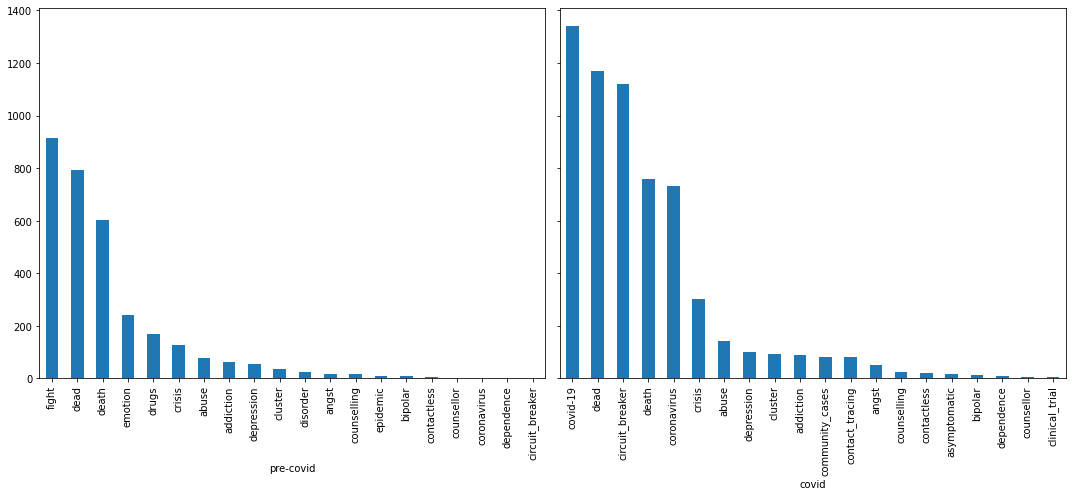

In [7]:
fig, ax = plt.subplots(nrows=1, ncols = 2, figsize=(15,7), sharey=True)
ax = ax.ravel()
df_keyword_trend_pre_covid.sort_values(ascending=False).plot(kind='bar', ax=ax[0])
ax[0].set_xlabel('pre-covid')

df_keyword_trend_covid.sort_values(ascending=False).plot(kind='bar', ax=ax[1])
ax[1].set_xlabel('covid')
plt.tight_layout()

In [8]:
# Groups all the text in a keyword category to find common words associated with the keyword
df_raw_pre_covid_group = df_raw_pre_covid.groupby(['id_search'], as_index=False)['clean_tweet4'].apply(' '.join)
df_raw_covid_group = df_raw_covid.dropna().groupby(['id_search'], as_index=False)['clean_tweet4'].apply(' '.join)

In [9]:
print(df_raw_pre_covid_group.shape)
print(df_raw_covid_group.shape)

(78, 2)
(95, 2)


# Global Settings

In [10]:
# These are the categories that you can search to explore the data
print(df_raw['id_search'].unique())

['depression' 'mental_illness' 'social_anxiety' 'loneliness' 'stress'
 'lonely' 'isolation' 'suicide' 'abuse' 'death' 'no_motivation' 'therapy'
 'trauma' 'counselling' 'mood_swings' 'mental_health' 'angst' 'emotion'
 'phobia' 'addiction' 'stigma' 'self-harm' 'disorder' 'dependence'
 'socialize' 'help' 'dead' 'tired' 'trapped' 'paranoia' 'overwhelmed'
 'irritable' 'bipolar' 'psychologist' 'well-being' 'imh' 'sos'
 'counsellor' 'toxic' 'insominia' 'drugs' 'fight' 'self-esteem' 'unalive'
 'melancholia' 'pandemic' 'circuit_breaker' 'quarantine' 'wfh' 'phase_2'
 'vaccine' 'epidemic' 'mask' 'contactless' 'national_emergency'
 'transmission' 'screening' 'testing' 'hospital' 'symptomatic' 'symptoms'
 'outbreak' 'cluster' 'spread' 'hygiene' 'crisis' 'new_normal'
 'uncertainty' 'zoom' 'retrenchment' 'variant' 'shn' 'hbl' 'safe_entry'
 'frontline' 'school_closure' 'job_insecurity' 'lockdown' 'coronavirus'
 'asymptomatic' 'contact_tracing' 'restriction' 'social_distancing'
 'fatality_rate' 'stay_h

In [11]:
ngram_start = 2
ngram_end = 2
max_keywords_rank = 20
keyword = 'suicide' # Run this block and then all the codes below

# TF-IDF (Pre-Covid)

In [12]:
# Performing TF-IDF
pre_covid_vectorizer = TfidfVectorizer(ngram_range=(ngram_start,ngram_end),
                            stop_words = 'english',
                            lowercase=True)

df_pre_covid_transformed = pre_covid_vectorizer.fit_transform(df_raw_pre_covid_group['clean_tweet4'])
df_pre_covid_tfidf = pd.DataFrame(df_pre_covid_transformed.toarray(), columns = pre_covid_vectorizer.get_feature_names())

# Merges the TF-IDF output with the main df so as to retrieve the keywords. In this implementation the
# tf-idf array produced does not have the keyword but merely the index location of the keyword
df_pre_covid = pd.concat([df_raw_pre_covid_group, df_pre_covid_tfidf], axis = 1)

# Clean tweets not needed
df_pre_covid = df_pre_covid.drop('clean_tweet4',axis=1)
df_pre_covid = df_pre_covid.reset_index()

# Changes into long form so as to sum the frequencies for every keyword search and the ngram TF-IDF produces
df_pre_covid_long = pd.melt(df_pre_covid, 
                            id_vars='index', 
                            value_vars = df_pre_covid.columns[2:])

df_pre_covid_long = df_pre_covid_long.merge(df_pre_covid[['index','id_search']], 
                                             on=['index'],
                                             how='left')

df_pre_covid_long = df_pre_covid_long.drop('index',axis=1) 

In [13]:
# Filters for the top 20 ngrams per keywrod search and sorts them
df_pre_covid_long['rank'] = (df_pre_covid_long.sort_values('value', ascending=False).groupby(['id_search']).cumcount()+1)
df_pre_covid_long = df_pre_covid_long[df_pre_covid_long['rank'] <= max_keywords_rank]
df_pre_covid_long = df_pre_covid_long.sort_values(['id_search', 'rank'], ascending=[True,True])

# TF-IDF (Covid)

In [14]:
# Performing TF-IDF
covid_vectorizer = TfidfVectorizer(ngram_range=(ngram_start,ngram_end),
                            stop_words = 'english',
                            lowercase=True)

# This block takes a while to run
df_covid_transformed = covid_vectorizer.fit_transform(df_raw_covid_group['clean_tweet4'])
df_covid_tfidf = pd.DataFrame(df_covid_transformed.toarray(), columns = covid_vectorizer.get_feature_names())

# Merges the TF-IDF output with the main df so as to retrieve the keywords. In this implementation the
# tf-idf array produced does not have the keyword but merely the index location of the keyword
df_covid = pd.concat([df_raw_covid_group, df_covid_tfidf], axis = 1)

# Clean tweets not needed
df_covid = df_covid.drop('clean_tweet4',axis=1)
df_covid = df_covid.reset_index()

# Changes into long form so as to sum the frequencies for every keyword search and the ngram TF-IDF produces
df_covid_long = pd.melt(df_covid, 
                        id_vars=df_covid.columns[0], 
                        value_vars = df_covid.columns[2:])

df_covid_long = df_covid_long.merge(df_covid[df_covid.columns[0:2]], 
                                    on=df_covid.columns[0],
                                    how='left')


df_covid_long = df_covid_long.drop(df_covid_long.columns[0],axis=1) 

In [15]:
# Filters for the top 20 ngrams per keywrod search and sorts them
top_n_words_per_category = 20

df_covid_long['rank'] = (df_covid_long.sort_values('value', ascending=False).groupby(['id_search']).cumcount()+1)
df_covid_long = df_covid_long[df_covid_long['rank'] <= max_keywords_rank]
df_covid_long = df_covid_long.sort_values(['id_search', 'rank'], ascending=[True,True])

# Keyword Exploration

In [16]:
# Explore keywords here for pre-covid
df_pre_covid_long[df_pre_covid_long['id_search'] == keyword]

,variable,value,id_search,rank
571099,case family,0.137692,suicide,1
183751,army isi,0.137692,suicide,2
3018583,people die,0.117283,suicide,3
947683,die die,0.117283,suicide,4
573127,cases org,0.068846,suicide,5
3514975,sadness anxiety,0.068846,suicide,6
4119241,terrible cesc,0.068846,suicide,7
3812545,slowly walk,0.068846,suicide,8
834739,dah legal,0.068846,suicide,9
554407,cara hannah,0.068846,suicide,10


In [17]:
# Explore keywords here for Covid period
df_covid_long[df_covid_long['id_search'] == keyword]

,variable,value,id_search,rank
10971627,press ups,0.107640,suicide,1
11181767,ptsd hurting,0.107640,suicide,2
15104982,ups raise,0.107640,suicide,3
3243092,days press,0.107640,suicide,4
6537977,hurting reach,0.107640,suicide,5
873507,awareness anxiety,0.107640,suicide,6
519537,anxiety ptsd,0.107640,suicide,7
9969187,original nomination,0.107640,suicide,8
2888172,craig bagshaw,0.107640,suicide,9
9583202,nomination craig,0.107640,suicide,10


# Jiong Jiet's Method (TF-IDF) but with category segmentation

## Comparison

Text(0.5, 1.0, 'Top ngrams during covid relating to: depression')

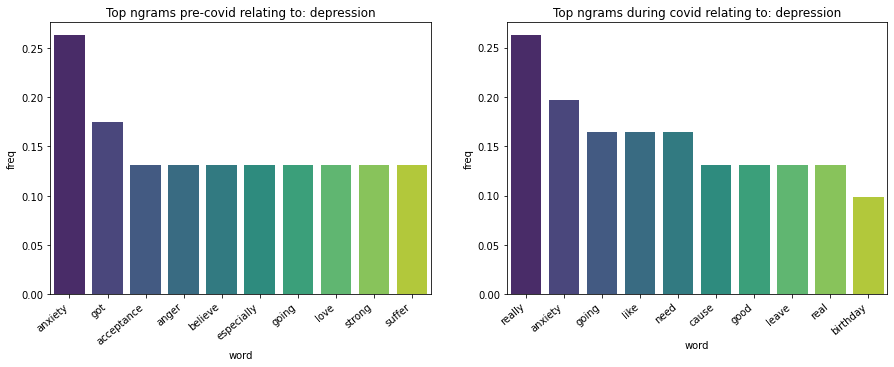

In [18]:
# Comparing with Tfidf vectorizer (Jiong jiet's method)
from sklearn.feature_extraction import text 
my_additional_sw = [ 'im', 'day']
stop_words = text.ENGLISH_STOP_WORDS.union(my_additional_sw)

# Category slice
keyword = 'depression'
topn = 10
ngram_start = 1
ngram_end = 1

# Vectorization Pre covid
Tfidf_pre_covid = TfidfVectorizer(stop_words=stop_words, ngram_range = (ngram_start,ngram_end))
bow_pre_covid = Tfidf_pre_covid.fit_transform(df_raw_pre_covid_group[df_raw_pre_covid_group['id_search']==keyword]['clean_tweet4'])
word_freq_pre_covid = dict(zip(Tfidf_pre_covid.get_feature_names(), np.asarray(bow_pre_covid.sum(axis=0)).ravel()))
word_counter_pre_covid = collections.Counter(word_freq_pre_covid)
word_counter_df_pre_covid = pd.DataFrame(word_counter_pre_covid.most_common(topn), columns = ['word', 'freq'])

# Vectorization during covid
Tfidf_covid = TfidfVectorizer(stop_words=stop_words, ngram_range = (ngram_start,ngram_end))
bow_covid = Tfidf_covid.fit_transform(df_raw_covid_group[df_raw_covid_group['id_search']==keyword]['clean_tweet4'])
word_freq_covid = dict(zip(Tfidf_covid.get_feature_names(), np.asarray(bow_covid.sum(axis=0)).ravel()))
word_counter_covid = collections.Counter(word_freq_covid)
word_counter_df_covid = pd.DataFrame(word_counter_covid.most_common(topn), columns = ['word', 'freq'])

# Plotting side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (15,5)) # length, height
ax = ax.ravel()

bar_freq_word = sns.barplot(x="word", y="freq", data=word_counter_df_pre_covid, palette="viridis", ax=ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=40, ha="right")
ax[0].set_title(f'Top ngrams pre-covid relating to: {keyword}')

bar_freq_word = sns.barplot(x="word", y="freq", data=word_counter_df_covid, palette="viridis", ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=40, ha="right")
ax[1].set_title(f'Top ngrams during covid relating to: {keyword}')



# WordCloud For Pre-Covid

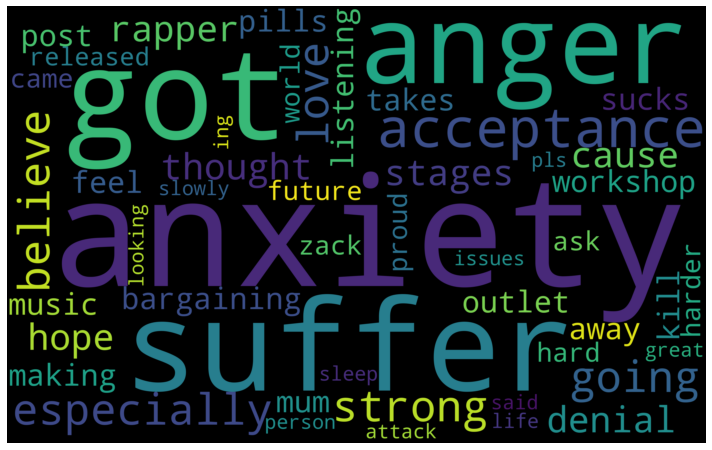

In [19]:
keyword_wordcloud = 'depression'
df_wordcloud_pre_covid = df_raw_pre_covid_group.groupby('id_search')['clean_tweet4'].apply(' '.join).reset_index(name='tweets')
df_wordcloud_covid = df_raw_covid_group.groupby('id_search')['clean_tweet4'].apply(' '.join).reset_index(name='tweets')

#add new stop words
add_stop_words= ["singapore", "covid", "like"]
stop_words= text.ENGLISH_STOP_WORDS.union(add_stop_words)
wordcloud_pre_covid = WordCloud(
                      background_color='black',
                      collocations = True,
                      stopwords=stop_words, 
                      width=4000, 
                      height=2500,
                     max_words = 50).generate(
    df_wordcloud_pre_covid.loc[df_wordcloud_pre_covid['id_search'] == keyword, 'tweets'].values[0])

# Display the generated image:
plt.figure(figsize=(10,10))
plt.axis("off")
plt.imshow(wordcloud_pre_covid, interpolation='bilinear')
# plt.title("Word Cloud for Covid & Mental related tweets", fontsize= 50)

plt.tight_layout()
#wordcloud.to_file("enjoyable_comp.png")

# Covid WordCloud

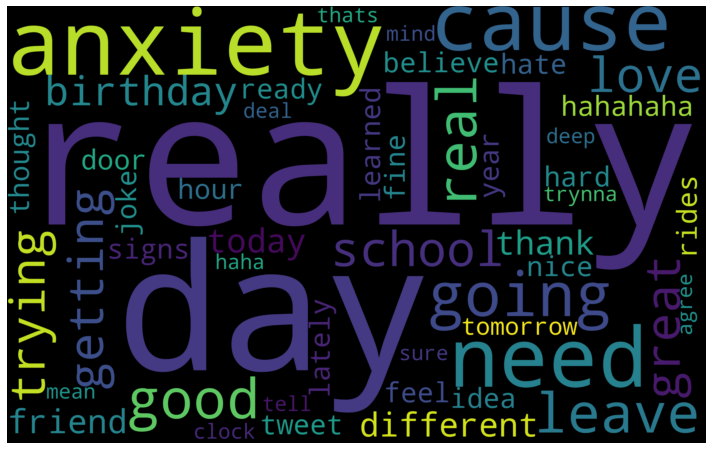

In [20]:
#add new stop words
add_stop_words= ["singapore", "covid", "like"]
stop_words= text.ENGLISH_STOP_WORDS.union(add_stop_words)
wordcloud_covid = WordCloud(
                      background_color='black',
                      collocations = True,
                      stopwords=stop_words, 
                      width=4000, 
                      height=2500,
                     max_words = 50).generate(
    df_wordcloud_covid.loc[df_wordcloud_covid['id_search'] == keyword, 'tweets'].values[0])

# Display the generated image:
plt.figure(figsize=(10,10))
plt.axis("off")
plt.imshow(wordcloud_covid, interpolation='bilinear')
# plt.title("Word Cloud for Covid & Mental related tweets", fontsize= 50)

plt.tight_layout()
#wordcloud.to_file("enjoyable_comp.png")